In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


/home/students/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [3]:
train_dir = '/home/students/Documents/Computer vision/image_classification_app/data/training'
test_dir = '/home/students/Documents/Computer vision/image_classification_app/data/testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # conversion en grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Vérifier les classes
print("Classes :", train_dataset.classes)


Classes : ['glioma', 'meningioma', 'notumor', 'pituitary']


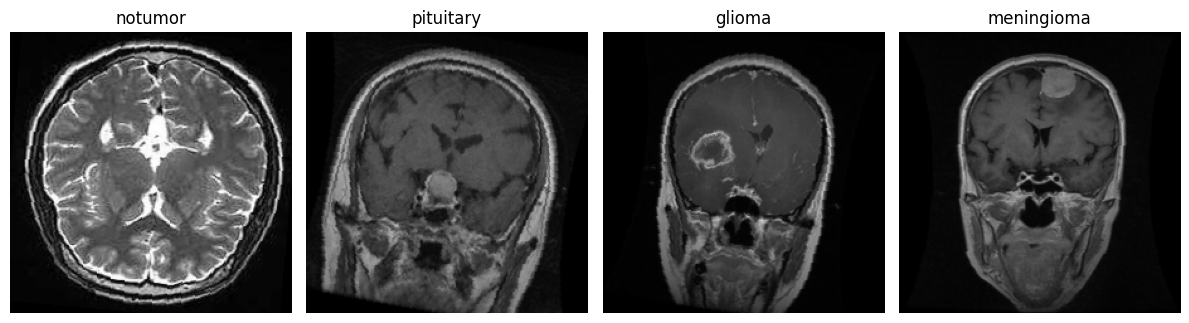

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher des images avec leur étiquette
def show_images_by_class(data_loader, class_names, num_images_per_class=2):
    shown = {cls: 0 for cls in class_names}
    max_total = len(class_names) * num_images_per_class
    images_shown = 0

    plt.figure(figsize=(12, 8))

    for images, labels in data_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            class_name = class_names[label]
            if shown[class_name] < num_images_per_class:
                image = images[i].numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
                image = image * 0.5 + 0.5  # Dé-normalisation (si normalisé avec mean=0.5, std=0.5)
                #plt.subplot(len(class_names), num_images_per_class, images_shown + 1)
                plt.subplot(1, max_total, images_shown + 1)  # Affichage en 1 ligne

                plt.imshow(image.squeeze(), cmap='gray' if image.shape[2]==1 else None)
                plt.title(class_name)
                plt.axis('off')
                shown[class_name] += 1
                images_shown += 1

            if images_shown >= max_total:
                plt.tight_layout()
                plt.show()
                return

# Utilisation de la fonction
show_images_by_class(train_loader, class_names=train_dataset.classes, num_images_per_class=1)


In [6]:
import torch.nn as nn

class CNN_PyTorch(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_PyTorch, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 👈 on remplace 1 par 3
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
#pip install tensorflow==2.11


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def create_tensorflow_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    base_model.trainable = False  # On gèle les poids du modèle pré-entraîné

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.8),  # Dropout à 50% pour régulariser
        layers.Dense(num_classes, activation='softmax')
    ])

    return model



2025-05-25 13:07:24.415563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 13:07:24.816646: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 13:07:24.874928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-25 13:07:24.874968: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Créer les datasets à partir des dossiers
train_generator = train_datagen.flow_from_directory(
    '/home/students/Documents/Computer vision/image_classification_app/data/training',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/home/students/Documents/Computer vision/image_classification_app/data/testing',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:


import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_PyTorch(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # à augmenter si besoin
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Sauvegarde du modèle
torch.save(model.state_dict(), "Pontiane_model.torch")



Epoch 1, Loss: 0.7943, Accuracy: 73.83%
Epoch 2, Loss: 0.3565, Accuracy: 86.43%
Epoch 3, Loss: 0.2515, Accuracy: 90.65%
Epoch 4, Loss: 0.1736, Accuracy: 93.75%
Epoch 5, Loss: 0.1387, Accuracy: 94.77%
Epoch 6, Loss: 0.1104, Accuracy: 96.24%
Epoch 7, Loss: 0.0700, Accuracy: 97.53%
Epoch 8, Loss: 0.0654, Accuracy: 97.93%
Epoch 9, Loss: 0.0537, Accuracy: 98.44%
Epoch 10, Loss: 0.0400, Accuracy: 98.65%


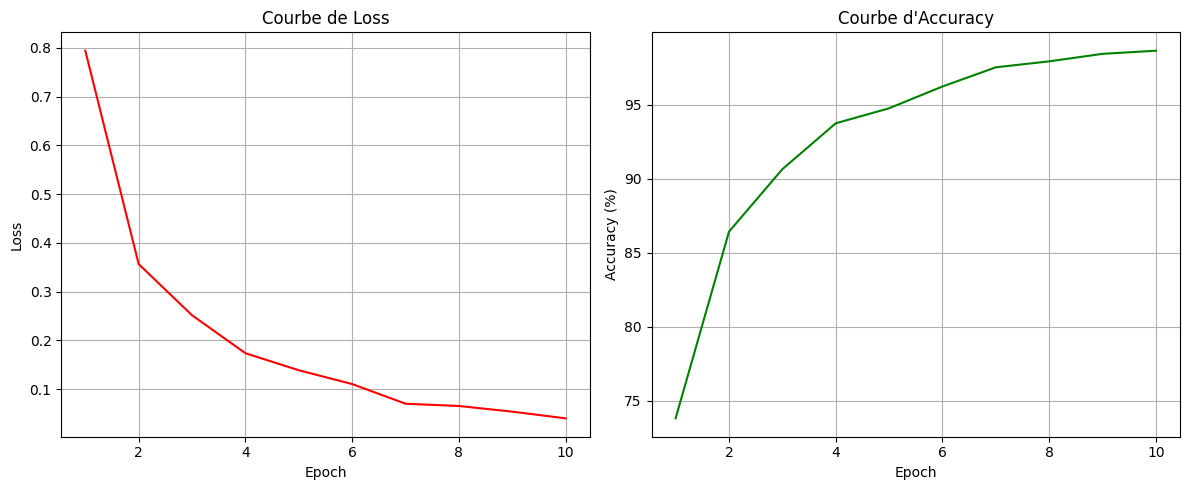

In [11]:

# 📈 Tracer la courbe de Loss et Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Courbe d\'Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
train_generator = train_datagen.flow_from_directory(
    '/home/students/Documents/Computer vision/image_classification_app/data/training',
    target_size=(224, 224),
    color_mode='rgb',   # <- changer ici
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/home/students/Documents/Computer vision/image_classification_app/data/testing',
    target_size=(224, 224),
    color_mode='rgb',   # <- changer ici
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Epoch 1/10
179/179 [==============================] - 99s 543ms/step - loss: 0.8308 - accuracy: 0.6719 - val_loss: 0.5418 - val_accuracy: 0.7773
Epoch 2/10
179/179 [==============================] - 94s 524ms/step - loss: 0.5797 - accuracy: 0.7714 - val_loss: 0.4420 - val_accuracy: 0.8330
Epoch 3/10
179/179 [==============================] - 94s 525ms/step - loss: 0.5084 - accuracy: 0.7994 - val_loss: 0.4436 - val_accuracy: 0.8230
Epoch 4/10
179/179 [==============================] - 98s 549ms/step - loss: 0.4943 - accuracy: 0.8109 - val_loss: 0.4442 - val_accuracy: 0.8238
Epoch 5/10
179/179 [==============================] - 104s 583ms/step - loss: 0.4639 - accuracy: 0.8186 - val_loss: 0.3816 - val_accuracy: 0.8551
Epoch 6/10
179/179 [==============================] - 104s 578ms/step - loss: 0.4344 - accuracy: 0.8321 - val_loss: 0.4358 - val_accuracy: 0.8360
Epoch 7/10
179/179 [==============================] - 102s 569ms/step - loss: 0.4239 - accuracy: 0.8318 - val_loss: 0.4080 - val

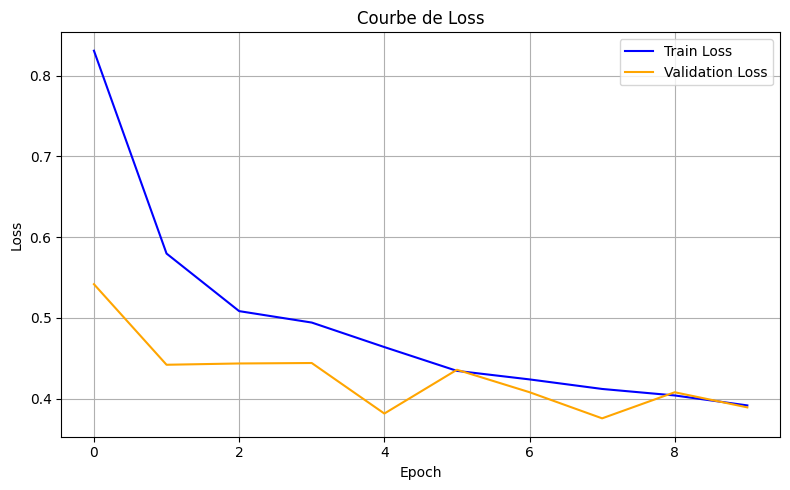

In [15]:
model_tf = create_tensorflow_model(input_shape=(224, 224, 3), num_classes=4)
model_tf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  #
    metrics=['accuracy']
)

# Entraînement du modèle
history = model_tf.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# 📈 Tracer les courbes de loss (train & validation)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Courbe de loss
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:

# Sauvegarde
model_tf.save("Pontian_model.tensorflow")

INFO:tensorflow:Assets written to: Pontian_model.tensorflow/assets


INFO:tensorflow:Assets written to: Pontian_model.tensorflow/assets


In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--framework', type=str, choices=['pytorch', 'tensorflow'], required=True)
args = parser.parse_args()

if args.framework == 'pytorch':
    # importer et exécuter l'entraînement PyTorch ici
    pass
elif args.framework == 'tensorflow':
    # importer et exécuter l'entraînement TensorFlow ici
    pass


In [18]:
def evaluate_pytorch(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy sur test set (PyTorch) : {accuracy:.2f}%')


In [19]:
def evaluate_tensorflow(model, test_generator):
    loss, accuracy = model.evaluate(test_generator)
    print(f'Accuracy sur test set (TensorFlow) : {accuracy*100:.2f}%')


In [20]:
from PIL import Image

def predict_pytorch(model, image_path, device, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # batch size 1
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    print(f'Prédiction PyTorch: {class_names[predicted.item()]}')


In [21]:
def predict_tensorflow(model, image_path, class_names):
    from tensorflow.keras.preprocessing import image
    import numpy as np

    img = image.load_img(image_path, color_mode='grayscale', target_size=(224,224))
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)  # batch size 1

    preds = model.predict(x)
    pred_class = class_names[np.argmax(preds)]
    print(f'Prédiction TensorFlow: {pred_class}')


In [22]:
# Evaluation PyTorch
evaluate_pytorch(model, test_loader, device)

# Evaluation TensorFlow
evaluate_tensorflow(model_tf, test_generator)


Accuracy sur test set (PyTorch) : 97.64%
41/41 [==============================] - 16s 387ms/step - loss: 0.3892 - accuracy: 0.8436
Accuracy sur test set (TensorFlow) : 84.36%


In [ ]:
from PIL import Image
import numpy as np

def predict_pytorch(model, image_path, device, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    print(f'Prediction PyTorch: {class_names[predicted.item()]}')
    return class_names[predicted.item()]

def predict_tensorflow(model, image_path, class_names):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, color_mode='grayscale', target_size=(224,224))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    pred_class = class_names[np.argmax(preds)]
    print(f'Prediction TensorFlow: {pred_class}')
    return pred_class
